# Linear Regression
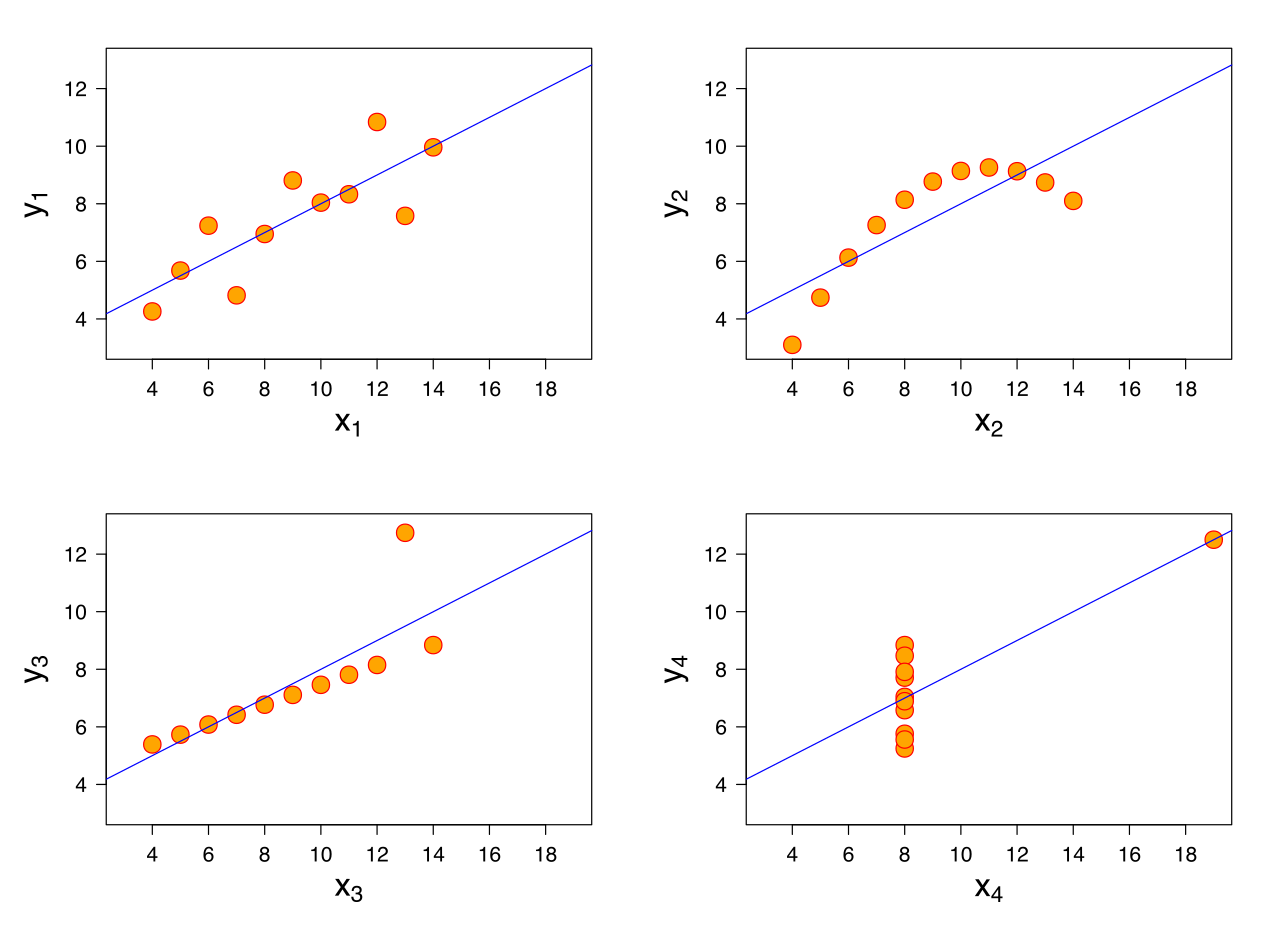

# Setup

In [277]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling 

from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#conda install -c districtdatalabs yellowbrick --yes
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as regplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from patsy import dmatrices

# Data

In [278]:
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [279]:
bostonDF = pd.DataFrame(boston['data'], columns=boston['feature_names'])
bostonDF['TARGET'] = boston['target']
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Categorical Features
* We'll fabricate age into a catagorical feature

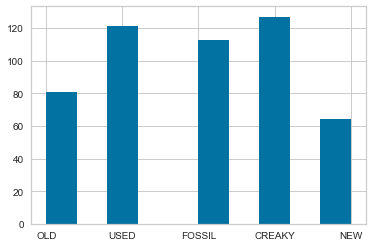

In [280]:
def ageBin(age):
    if age < 30: return 'NEW'
    if age < 60: return 'USED'
    if age < 80: return 'OLD'
    if age < 95: return 'CREAKY'
    return 'FOSSIL'
bostonDF['AGE_BIN'] = bostonDF['AGE'].apply(ageBin)
bostonDF['AGE_BIN'].hist()

## EDA

In [281]:
pandas_profiling.ProfileReport(bostonDF)

# Preprocessing

## Flow Helpers

In [282]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

## Age 

In [283]:
bostonDF['AGE_BIN'] = bostonDF['AGE_BIN'].astype('category')
bostonDF = bostonDF.drop('AGE', axis=1)

## Build Pipeline

In [284]:
process = make_pipeline(
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            OneHotEncoder(categories='auto', drop='first')
        ))
    ])
)


# Loss Metrics
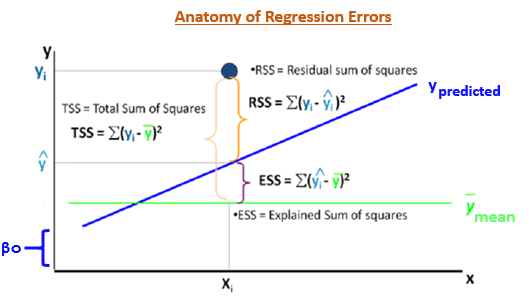

## Explained Variance
* Talking point - What is R-Squared?
* ESS / TSS

## MAE
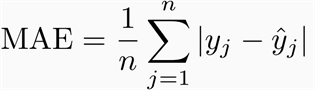
* Measures average model bias
* Easy to explain

## MSE
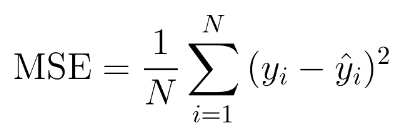
* Measures the average squared error magnitude
* Not in units of the prediction
* Hard to explain / conceptualize

## RMSE
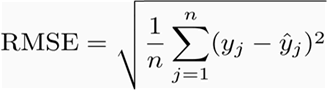
* In the same units of the prediction
* Measures the average magnitude of the error
* Larger errors result in larger RMSE (from squaring the term)

## MAPE & Accuracy
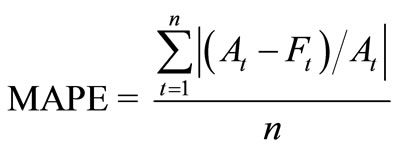

## RMSE vs MAE
https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d

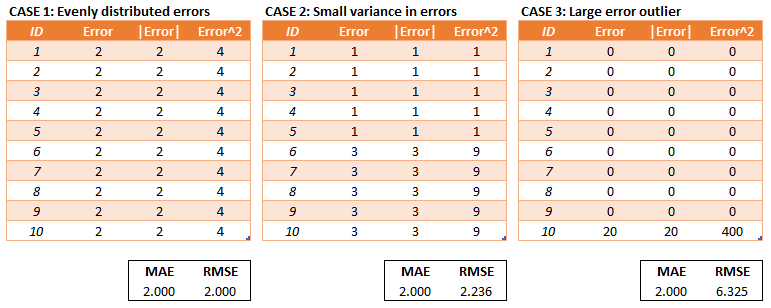

# Model

## Tracking

In [285]:
resultsDF = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE'])
compareDF = pd.DataFrame()

## Fit

In [286]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

clf = LinearRegression()
pipe = Pipeline(steps=[('process', process), ('regression', clf)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print('MAE  = {:.2f}'.format(mae))
print('MSE  = {:.2f}'.format(mse))
print('RMSE = {:.2f}'.format(rmse))

resultsDF.loc['OLS'] = [mae, mse, rmse]
compareDF = pd.concat([compareDF, pd.DataFrame(clf.coef_)], axis=1)

MAE  = 3.26
MSE  = 23.35
RMSE = 4.83


In [324]:
errors = abs(y_test - pred)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('MAPE     : {:.2f}%'.format(np.mean(mape)))
print('Accuracy : {:.2f}%'.format(accuracy))

MAPE     : 21.43%
Accuracy : 78.57%


## Prediction Error

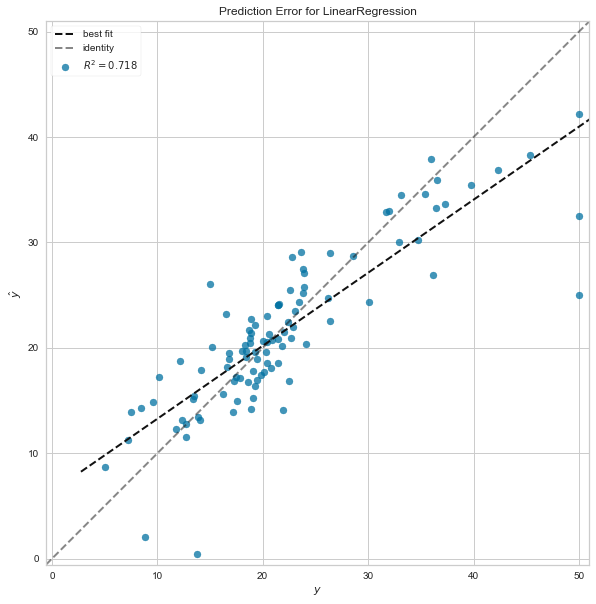

In [287]:
plt.figure(figsize=(15,10))
visualizer = PredictionError(pipe)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## Residuals Plot
* We should look for a cloud like shape (no other pattern)

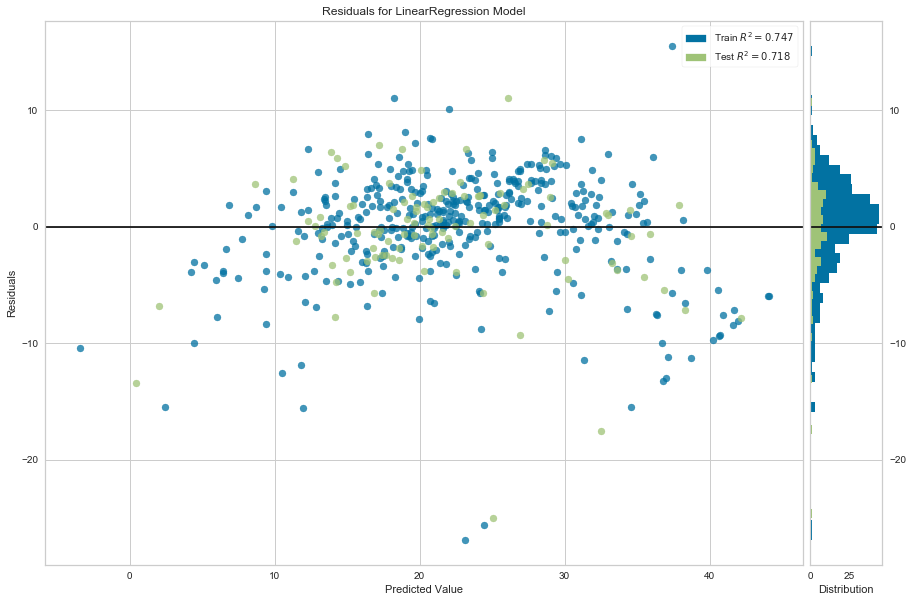

In [288]:
plt.figure(figsize=(15,10))
visualizer = ResidualsPlot(pipe)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof() 

# Interpretation

## StatsModel

In [289]:
tDF = pd.concat([X_train, y_train], axis=1)
f = 'TARGET ~ CRIM + ZN + INDUS + CHAS + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT + AGE_BIN'
lm = smf.ols(formula=f, data=tDF).fit()

## Summary

In [290]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 TARGET   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     71.45
Date:                Mon, 05 Aug 2019   Prob (F-statistic):          9.11e-105
Time:                        06:09:06   Log-Likelihood:                -1192.3
No. Observations:                 404   AIC:                             2419.
Df Residuals:                     387   BIC:                             2487.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            33.7007      5.97

## Partial Regression Plots
Creates a partial regression subplot for each explanatory variable. Each plot shows the relationship between the response and the given explanatory variable after removing the effect of all other explanatory variables.  These plots are helpful in describing the effect of one variable's effect.

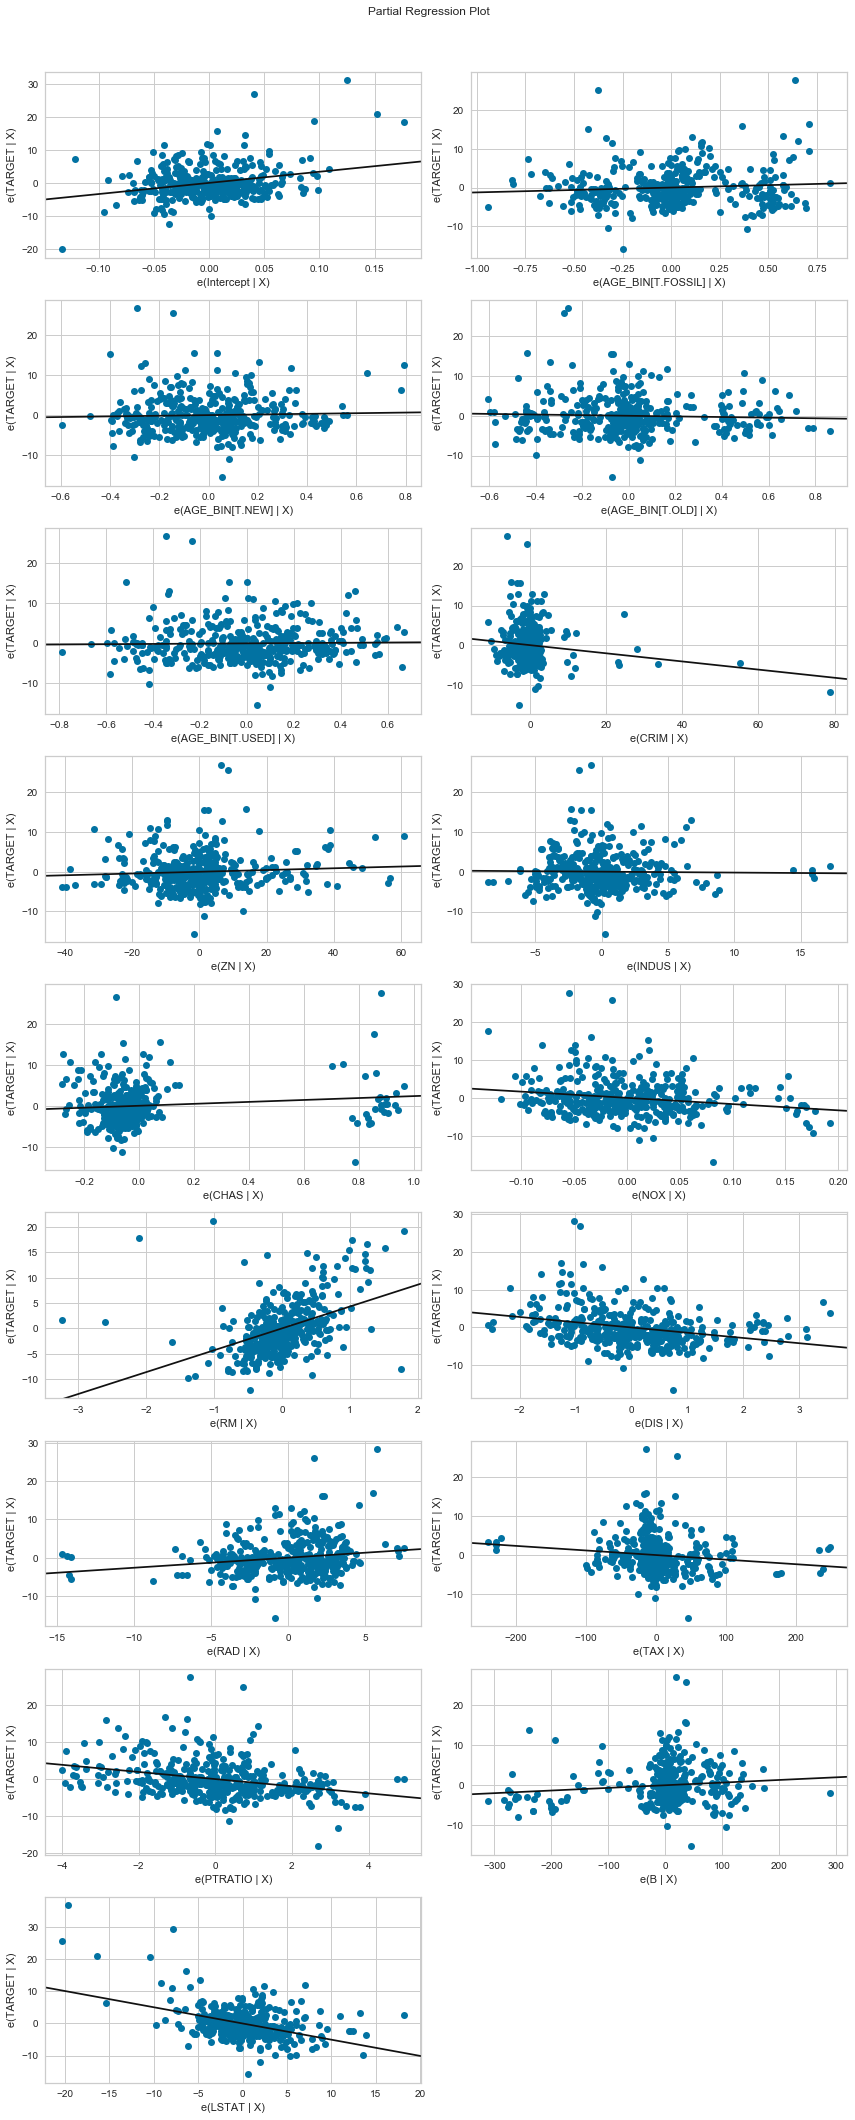

In [291]:
fig = plt.figure(figsize=(12,30))
fig = sm.graphics.plot_partregress_grid(lm, fig=fig)

# Assumptions

## L (inear)
* Data should be visibly linear - hard to do in high dimensional spaces
* You can attempt to fit polynomial independent variables or apply other transformation to capture / fit the non-linerity
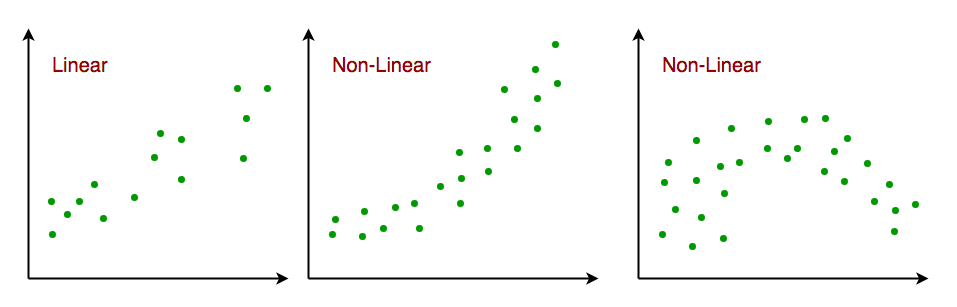

## I (ndependent)
* Each data point should be independent. 
* We want to avoid colinearity
 * When we have high correlation on two features, there is little information from both in the model
 * Consider dropping out one of the correlated features
* Example violations of this assumption 
 * Include time series (which can introduce autocorrelation)
 * Height regression that includes height of left leg and height of right leg in model

### Variable Inflation Factor
Variance Inflation Factor (VIF) measures the colinearity of predictor variables. VIF is the ratio of the variance of all model's coefficients divided by the variance of a single coefficient if it were fit in isolation.  

In [292]:
variables = lm.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vifDF = pd.DataFrame()
vifDF['Coefficient'] = lm.params
vifDF['VIF'] = vif
vifDF['Flag'] = np.where(vifDF.VIF > 5, True, False)
vifDF = vifDF.drop('Intercept', axis=0)
vifDF

,Coefficient,VIF,Flag
AGE_BIN[T.FOSSIL],1.247437,1.702363,False
AGE_BIN[T.NEW],0.796080,2.496762,False
AGE_BIN[T.OLD],-0.785411,1.662618,False
AGE_BIN[T.USED],0.353033,2.657472,False
CRIM,-0.103085,1.827122,False
ZN,0.022089,2.440392,False
INDUS,-0.022603,4.387071,False
CHAS,2.360390,1.085797,False
NOX,-16.448766,4.419138,False
RM,4.312501,1.926968,False


### Correlation RAD & TAX
* These two features are highly correlated and score high on the VIF.
 * RAD = index of accessibility to radial highways
 * TAX = full-value property-tax rate per $10,000

In [293]:
print(np.corrcoef(df.TAX, df.RAD))

[[1.         0.91022819]
 [0.91022819 1.        ]]


## N (ormally Disributed Residuals)
* Residuals should be cloud shaped with no discernable pattern
* Check highly influential points (possible outliers)

### Residual Plot

Text(0, 0.5, 'Residual')

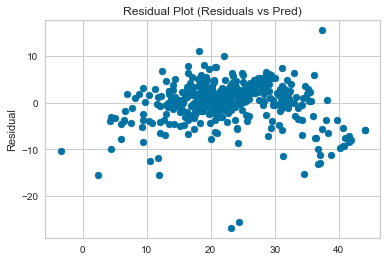

In [294]:
preds = lm.predict(X_train)
plt.scatter(preds, -lm.resid)
plt.title('Residual Plot (Residuals vs Pred)')
plt.ylabel('Residual')

### Jarque Bera Test for Normality

In [295]:
cols = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(lm.resid)
pd.DataFrame(zip(cols, test)).T

,0,1,2,3
0,Jarque-Bera,Chi^2 two-tail prob.,Skew,Kurtosis
1,632.62,4.24927e-138,1.47013,8.37925


### Leverage & Influence Plot
Leverage
* The ability to exert influence over the model
* Measures of how far an observation on the predictor variable is from from the mean of the predictor. 
* The higher the leverage value, the more potential it has to impact the fitted model.

Influence
* Degree to which the data point affects the model. 
* Measures the effect of a point on the regression model's predictions.
* A high influence point usually has leverage.

Watch for:
* High leverage and large residual - No points
* High Leverage and small residual - Point (380)
* Low Leverage and large residual - Points (372, 368, 364)

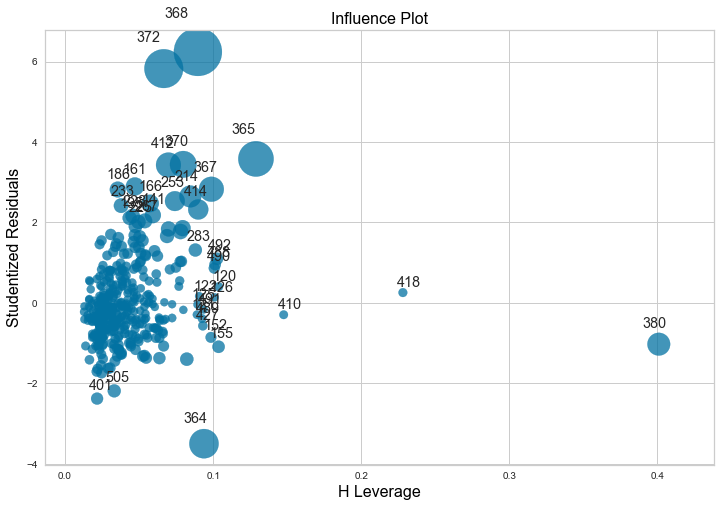

In [296]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, ax=ax, criterion="cooks")

### High Leverage Points

In [297]:
points = [380, 418]
X_train[X_train.index.isin(points)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,AGE_BIN
418,73.5341,0.0,18.1,0.0,0.679,5.957,1.8026,24.0,666.0,20.2,16.45,20.62,FOSSIL
380,88.9762,0.0,18.1,0.0,0.671,6.968,1.4165,24.0,666.0,20.2,396.90,17.21,CREAKY


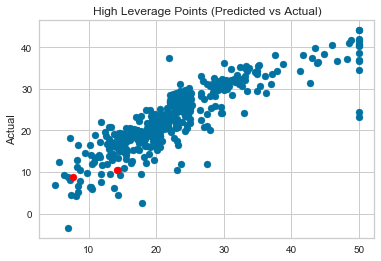

In [298]:
pred = lm.predict(X_train)
plt.title('High Leverage Points (Predicted vs Actual)')
plt.scatter(y_train, pred)
plt.ylabel('Actual')
for pt in points:
    plt.scatter(pred.loc[pt], y_train.loc[pt], color='red')

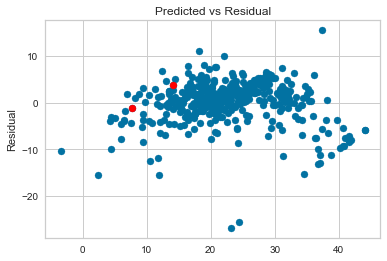

In [299]:
preds = lm.predict(X_train)
plt.scatter(preds, -lm.resid)
plt.ylabel('Residual')
plt.title('Predicted vs Residual')
for pt in points:
    plt.scatter(pred.loc[pt], -lm.resid[pt], color='red')

### Large Residual Points

In [300]:
points = [364, 372, 368]
X_train[X_train.index.isin(points)]

,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,AGE_BIN
364,3.47428,0.0,18.1,1.0,0.718,8.780,1.9047,24.0,666.0,20.2,354.55,5.29,CREAKY
368,4.89822,0.0,18.1,0.0,0.631,4.970,1.3325,24.0,666.0,20.2,375.52,3.26,FOSSIL
372,8.26725,0.0,18.1,1.0,0.668,5.875,1.1296,24.0,666.0,20.2,347.88,8.88,CREAKY


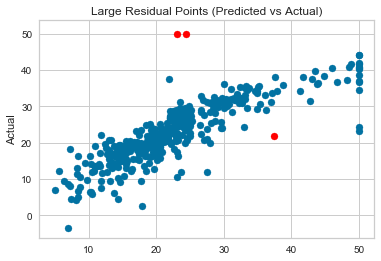

In [301]:
pred = lm.predict(X_train)
plt.title('Large Residual Points (Predicted vs Actual)')
plt.scatter(y_train, pred)
plt.ylabel('Actual')
for pt in points:
    plt.scatter(pred.loc[pt], y_train.loc[pt], color='red')

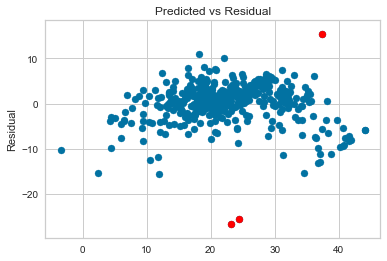

In [302]:
preds = lm.predict(X_train)
plt.scatter(preds, -lm.resid)
plt.ylabel('Residual')
plt.title('Predicted vs Residual')
for pt in points:
    plt.scatter(pred.loc[pt], -lm.resid[pt], color='red')

## E (rror constant)
* Homoskedasticity vs Heteroskedasticity
 * Example - As income goes up our predicted error increases
 * Example - As we play more minutes of basketball our predicted scoring error increases
* Typically spot with visual plot of residual vs predicted value (look for cone shape)
* If find heteroskedasticity we typically:
 * Adjust the model - add / drop featurews
 * Box Cox (log / sqrt / power) transforms on features and the target

### Visual Inspection
* There is some structure to the residual plot. 
* Indicative of heteroksedaticity

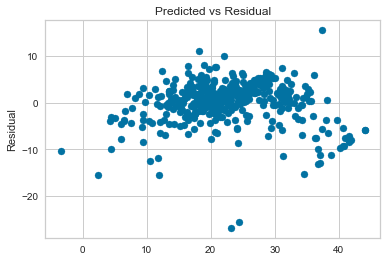

In [303]:
preds = lm.predict(X_train)
plt.scatter(preds, -lm.resid)
plt.ylabel('Residual')
plt.title('Predicted vs Residual')
plt.show()

### Breush Pagan Test
Produces a p-value that when less that a significance level of 0.05, therefore we can reject the null hypothesis that the variance of the residuals is constant and infer that heteroscedasticity is present.

In [304]:
cols = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(lm.resid, lm.model.exog)
pd.DataFrame(zip(cols, test)).T

,0,1,2,3
0,Lagrange multiplier statistic,p-value,f-value,f p-value
1,61.9112,2.4857e-07,4.37745,5.99602e-08


# Regularization
Adding features to Linear Regression will always have the effect of improving R-Squared.  To mitigate the chance of overfitting (fitting noise in the data) we want to penalize higher larger coefficients using L1 or L2 Norms.  The choice of L1 or L2 has an important effect.

## Norms
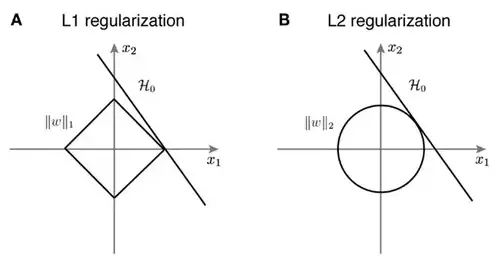

* Norm is the length of all vectors in a space
* L1 Norm
 * Manhattan Distance
 * Sum of absolute values of coefficients
* L2 Norm
 * Euclidean Distance
 * Sum of squared coefficients
* L1 and / or L2 are added to the cost function
 * Large coefficients result in higher penalty

## Lasso - L1 Regularization
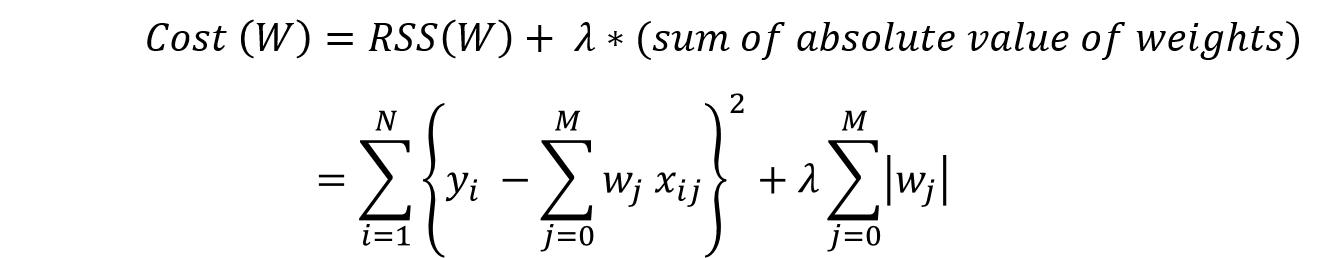

### Model

In [305]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

clf = Lasso()
pipe = Pipeline(steps=[('process', process), ('regression', clf)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print('MAE  = {:.2f}'.format(mae))
print('MSE  = {:.2f}'.format(mse))
print('RMSE = {:.2f}'.format(rmse))
resultsDF.loc['Lasso'] = [mae, mse, rmse]
compareDF = pd.concat([compareDF, pd.DataFrame(clf.coef_)], axis=1)

MAE  = 3.85
MSE  = 33.71
RMSE = 5.81


### Alpha Hyperparameter

In [306]:
hyperDF = pd.DataFrame()
alpha = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
cols  = []
for a in alpha:
    col = 'Alpha-{}'.format(a)
    clf = Lasso(alpha=a)
    pipe = Pipeline(steps=[('process', process), ('regression', clf)])
    pipe.fit(X_train, y_train)
    hyperDF[col] = clf.coef_
hyperDF = hyperDF.sort_values('Alpha-0.0')

Text(0.5, 1.0, 'Lasso - Alpha 1.0')

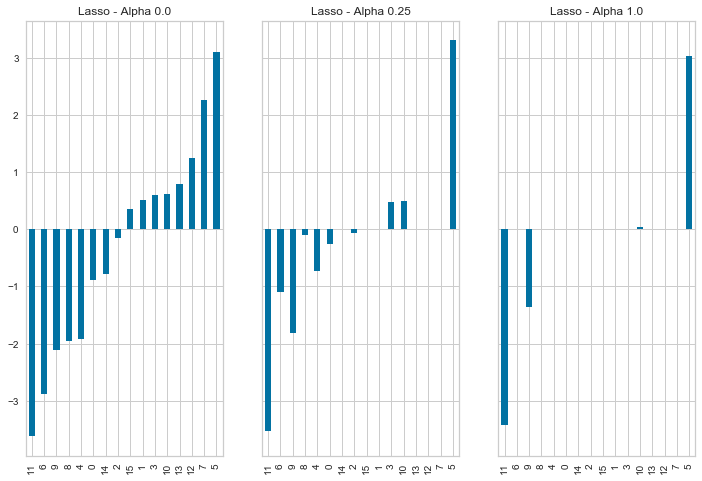

In [307]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax1 = hyperDF['Alpha-0.0'].plot.bar(ax=ax1)
ax1.set_title('Lasso - Alpha 0.0')
ax2 = hyperDF['Alpha-0.25'].plot.bar(ax=ax2)
ax2.set_title('Lasso - Alpha 0.25')
ax3 = hyperDF['Alpha-1.0'].plot.bar(ax=ax3)
ax3.set_title('Lasso - Alpha 1.0')

## Ridge - L2 Regularization
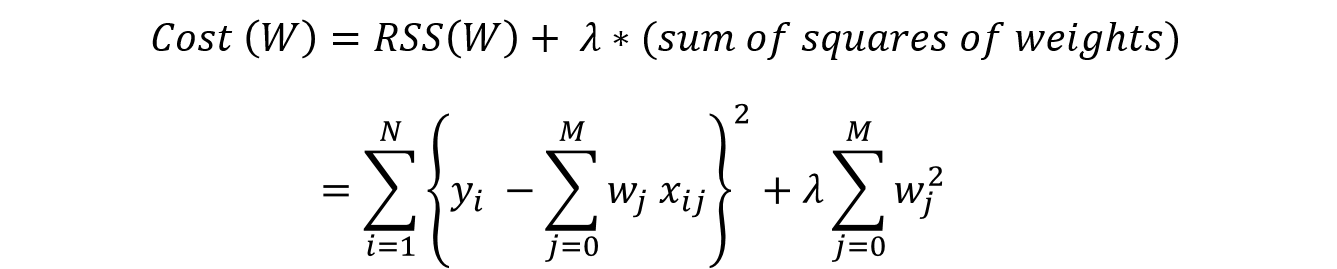

### Model

In [308]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

clf = Ridge()
pipe = Pipeline(steps=[('process', process), ('regression', clf)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print('MAE  = {:.2f}'.format(mae))
print('MSE  = {:.2f}'.format(mse))
print('RMSE = {:.2f}'.format(rmse))
resultsDF.loc['Ridge'] = [mae, mse, rmse]
compareDF = pd.concat([compareDF, pd.DataFrame(clf.coef_)], axis=1)

MAE  = 3.24
MSE  = 23.31
RMSE = 4.83


### Alpha Hyperparameter

In [320]:
hyperDF = pd.DataFrame()
alpha = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0, 500.0]
cols  = []
for a in alpha:
    col = 'Ridge-{}'.format(a)
    clf = Ridge(alpha=a)
    pipe = Pipeline(steps=[('process', process), ('regression', clf)])
    pipe.fit(X_train, y_train)
    hyperDF[col] = clf.coef_
hyperDF = hyperDF.sort_values('Ridge-0.0')

Text(0.5, 1.0, 'Ridge - Alpha 500.0')

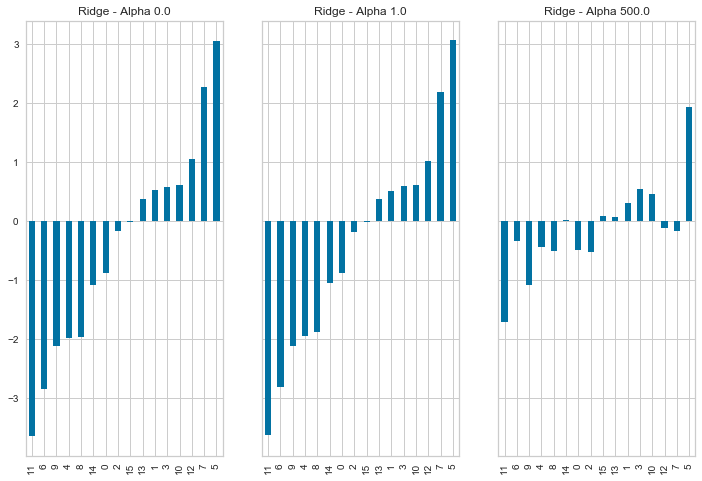

In [321]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax1 = hyperDF['Ridge-0.0'].plot.bar(ax=ax1)
ax1.set_title('Ridge - Alpha 0.0')
ax2 = hyperDF['Ridge-1.0'].plot.bar(ax=ax2)
ax2.set_title('Ridge - Alpha 1.0')
ax3 = hyperDF['Ridge-500.0'].plot.bar(ax=ax3)
ax3.set_title('Ridge - Alpha 500.0')

## Ridge vs Lasso
* Lasso moves several exogenous variables to 0.0

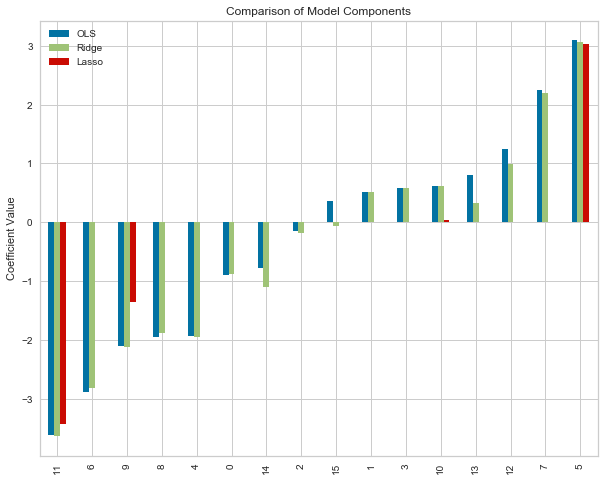

In [322]:
fig, ax = plt.subplots(figsize=(10,8))
compareDF.columns = ['OLS', 'Lasso', 'Ridge']
compareDF = compareDF.sort_values('OLS')
plt.title('Comparison of Model Components')
plt.ylabel('Coefficient Value')
compareDF[['OLS', 'Ridge', 'Lasso']].plot.bar(ax=ax)

## ElasticNet - Lasso + Ridge

In [312]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

for l1 in np.arange(0.1, 1, 0.1):
    clf = ElasticNet(l1_ratio=l1)
    pipe = Pipeline(steps=[('process', process), ('regression', clf)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    mae  = mean_absolute_error(y_test, pred)
    mse  = mean_squared_error(y_test, pred)
    rmse = math.sqrt(mse)
    classifier = 'ElasticNet - L1={:.1f}  L2={:.1f}'.format(l1, 1.0 - l1)
    print ('{} MAE {:.3f} MSE {:.3f} RMSE {:.3f}'.format(classifier, mae, mse, rmse))
    resultsDF.loc[classifier] = [mae, mse, rmse]

ElasticNet - L1=0.1  L2=0.9 MAE 4.002 MSE 34.194 RMSE 5.848
ElasticNet - L1=0.2  L2=0.8 MAE 3.977 MSE 34.130 RMSE 5.842
ElasticNet - L1=0.3  L2=0.7 MAE 3.965 MSE 34.183 RMSE 5.847
ElasticNet - L1=0.4  L2=0.6 MAE 3.970 MSE 34.387 RMSE 5.864
ElasticNet - L1=0.5  L2=0.5 MAE 3.953 MSE 34.248 RMSE 5.852
ElasticNet - L1=0.6  L2=0.4 MAE 3.928 MSE 34.032 RMSE 5.834
ElasticNet - L1=0.7  L2=0.3 MAE 3.901 MSE 33.865 RMSE 5.819
ElasticNet - L1=0.8  L2=0.2 MAE 3.883 MSE 33.758 RMSE 5.810
ElasticNet - L1=0.9  L2=0.1 MAE 3.867 MSE 33.772 RMSE 5.811


# Comparison
* ElasticNet L1 = 1.0 == Lasso
* ElasticNet L2 = 1.0 == Ridge (Warning unsable l1_ratio < 0.01)
* Lasso or Ridge with Alpha = 0.0 == OLS

## Top By RMSE

In [313]:
resultsDF.sort_values('RMSE')

,MAE,MSE,RMSE
Ridge,3.241759,23.305383,4.827565
OLS,3.255763,23.348944,4.832074
Lasso,3.850945,33.710895,5.806108
ElasticNet - L1=0.8 L2=0.2,3.883378,33.758333,5.810192
ElasticNet - L1=0.9 L2=0.1,3.866774,33.771558,5.811330
ElasticNet - L1=0.7 L2=0.3,3.900804,33.864504,5.819322
ElasticNet - L1=0.6 L2=0.4,3.927706,34.031639,5.833664
ElasticNet - L1=0.2 L2=0.8,3.977364,34.130092,5.842097
ElasticNet - L1=0.3 L2=0.7,3.965379,34.183209,5.846641
ElasticNet - L1=0.1 L2=0.9,4.002250,34.193813,5.847548


## Top By MAE

In [314]:
resultsDF.sort_values('MAE')

,MAE,MSE,RMSE
Ridge,3.241759,23.305383,4.827565
OLS,3.255763,23.348944,4.832074
Lasso,3.850945,33.710895,5.806108
ElasticNet - L1=0.9 L2=0.1,3.866774,33.771558,5.811330
ElasticNet - L1=0.8 L2=0.2,3.883378,33.758333,5.810192
ElasticNet - L1=0.7 L2=0.3,3.900804,33.864504,5.819322
ElasticNet - L1=0.6 L2=0.4,3.927706,34.031639,5.833664
ElasticNet - L1=0.5 L2=0.5,3.952527,34.247912,5.852172
ElasticNet - L1=0.3 L2=0.7,3.965379,34.183209,5.846641
ElasticNet - L1=0.4 L2=0.6,3.970090,34.387110,5.864052


## Notes
* Consider regularization as a default for predicting Linear Models
 * Ridge promotes coefficients close to zero
 * Lasso promotes sparsity and can be used for feature selection
 * In this example, Lasso kept 3 - 4 non-zero features + Intercept
 * Ridge kept all features 
 * Lasso / Ridge can change coefficients quite dramatically (positive to negative) with different levels of alpha
* Remember Assumptions
 * LINE
 * Inspect Residuals & Prediction Plots
 * Look for High Leverage Points
* Produce multiple metrics 
 * Remember differences between MAE & RMSE
 * R-Squared is intuitive but limited
* Stick to SKlearn if your objective is highest accuracy.
 * Easy to swap in / out estimators
 * Pipeline support is helpful
* Consider Statsmodel / R if you're modeling Linear Regression and want deep explanatory capabaility
 * Statsmodel has support for Lasso / Risge with .fit_regularized (0 <= L1_wt <= 1)  